In [1]:
import json
import warnings
from collections import namedtuple

import joblib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, fbeta_score, roc_auc_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree

sns.set()
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("data/train_data.csv")

In [3]:
data.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [4]:
data.shape

(7160, 14)

In [5]:
data["Claim"].value_counts()

0    5526
1    1634
Name: Claim, dtype: int64

In [6]:
data.describe()

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,Claim
count,7160.000000,7160.000000,7160.000000,7054.000000,7160.000000,6652.000000,7160.000000
mean,2013.669553,0.909758,0.305447,1883.727530,2.186034,1964.456404,0.228212
std,1.383769,0.239756,0.460629,2278.157745,0.940632,36.002014,0.419709
min,2012.000000,0.000000,0.000000,1.000000,1.000000,1545.000000,0.000000
25%,2012.000000,0.997268,0.000000,528.000000,2.000000,1960.000000,0.000000
50%,2013.000000,1.000000,0.000000,1083.000000,2.000000,1970.000000,0.000000
75%,2015.000000,1.000000,1.000000,2289.750000,3.000000,1980.000000,0.000000
max,2016.000000,1.000000,1.000000,20940.000000,4.000000,2016.000000,1.000000


In [7]:
data.describe(include='O')

,Customer Id,Building_Painted,Building_Fenced,Garden,Settlement,NumberOfWindows,Geo_Code
count,7160,7160,7160,7153,7160,7160,7058
unique,7160,2,2,2,2,11,1307
top,H14663,V,N,O,R,.,6088
freq,1,5382,3608,3602,3610,3551,143


## Understanding & Preparing your Data

In [8]:
data.NumberOfWindows.value_counts()

   .    3551
4        939
3        844
5        639
2        363
6        306
7        211
8        116
1         75
>=10      67
9         49
Name: NumberOfWindows, dtype: int64

In [9]:
data["NumberOfWindows"] = data["NumberOfWindows"].replace({"   .": 0, ">=10": 10}).astype(int)

### Handling Missing Values

In [10]:
# How many rows contain a missing value?
data.isnull().any(axis=1).sum()

617

In [11]:
# How many missing values are in each column?
data.isnull().sum()

Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  7
Settlement              0
Building Dimension    106
Building_Type           0
Date_of_Occupancy     508
NumberOfWindows         0
Geo_Code              102
Claim                   0
dtype: int64

In [12]:
data.dropna(how="any", inplace=True)

In [13]:
data.shape

(6543, 14)

### Encoding Features

In [14]:
categorical_columns = ["Building_Painted", "Building_Fenced", "Garden", "Settlement"]

In [15]:
encoder = OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False)

In [16]:
encoder.fit(data[categorical_columns])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [17]:
data[categorical_columns] = encoder.transform(data[categorical_columns])

In [18]:
data[categorical_columns]

,Building_Painted,Building_Fenced,Garden,Settlement
0,0.0,1.0,1.0,1.0
1,1.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,1.0,0.0,0.0,0.0
...,...,...,...,...
7053,1.0,0.0,0.0,0.0
7054,0.0,1.0,1.0,1.0
7055,0.0,1.0,1.0,1.0
7056,0.0,1.0,1.0,1.0


### Checking Correlation Between Features

In [19]:
data[categorical_columns].corr()

,Building_Painted,Building_Fenced,Garden,Settlement
Building_Painted,1.000000,-0.630711,-0.630907,-0.630907
Building_Fenced,-0.630711,1.000000,0.999691,0.999691
Garden,-0.630907,0.999691,1.000000,1.000000
Settlement,-0.630907,0.999691,1.000000,1.000000


<AxesSubplot:>

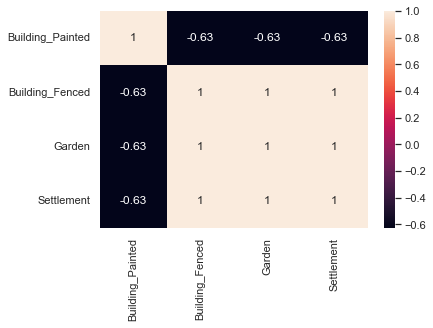

In [20]:
sns.heatmap(data[categorical_columns].corr(), annot=True)

### Dropping Features

In [21]:
dropped_columns = ["Geo_Code", "Garden", "Settlement", "Customer Id"]

In [22]:
data.drop(dropped_columns, axis=1, inplace=True)

In [23]:
data.shape

(6543, 10)